# 1. Load datas

In [56]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats, special

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [86]:
datas = pd.read_csv('./processed_datas/processed_data_2021.csv', encoding='cp949')
datas.index.name = 'id'
datas.columns = ['Unnamed: 0', 'min_park', 'min_book', 'min_elementary', 'min_midsc',
       'min_highsc', 'min_earthquake', 'min_emergency', 'hospital_1.0km',
       'hospital_2.5km', 'bus_0.1km', 'bus_0.3km', 'bus_0.5km', 'house_area',
       'PRICE', 'house_type', 'station_0.5km', 'station_1.0km',
       'station_1.5km', 'town_name']
datas.drop(columns = ['Unnamed: 0'], inplace = True)

In [80]:
def show_heatmap(df, target_col='PRICE'):
    corr = df.corr()
    top_corr=df[corr.nlargest(40,target_col)[target_col].index].corr()
    figure, ax1 = plt.subplots(nrows=1, ncols=1)
    figure.set_size_inches(20,15)
    sns.heatmap(top_corr, annot=True, ax=ax1)

In [87]:
# Remove outliers
filt = datas['min_park'] < 2
datas = datas[filt]

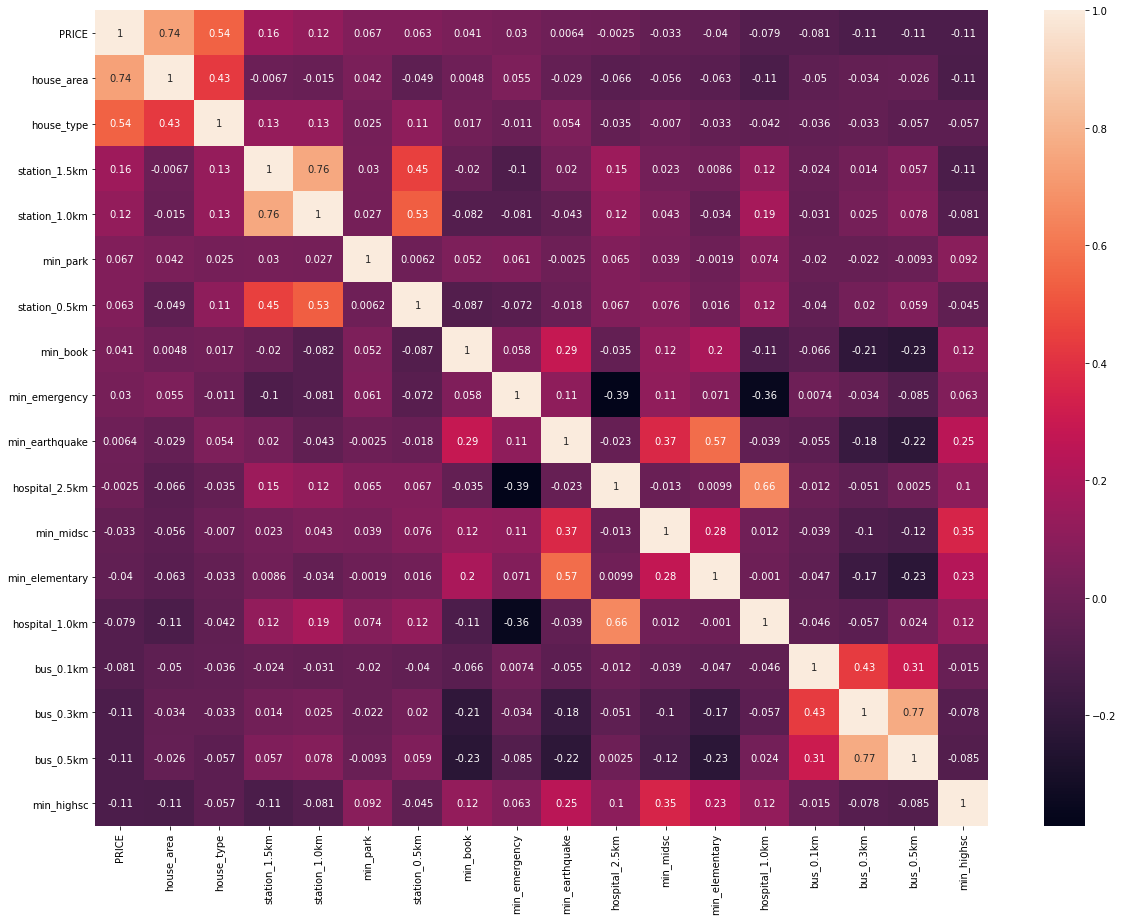

In [60]:
show_heatmap(datas)

### Skewness handling

In [61]:
def show_skewness(target_col, datas=datas):
    figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
    figure.set_size_inches(21,7)
    sns.distplot(datas[target_col], fit=norm, ax=ax1)
    sns.distplot(np.log(datas[target_col]+1), fit=norm, ax=ax2)
    sns.distplot(stats.boxcox(datas[target_col]+0.0001)[0], fit=norm, ax=ax3)

    print(f"Original skew: {datas[target_col].skew()}")
    print(f"Log skew: {np.log(datas[target_col]+1).skew()}")
    print(f"Coxbox skew: {pd.Series(stats.boxcox(datas[target_col]+0.0001)[0]).skew()}")

In [62]:
lmbda = stats.boxcox(datas['PRICE']+0.0001)[1]

Original skew: 4.392476609573868
Log skew: 0.44631454962795913
Coxbox skew: 0.03018942214657406


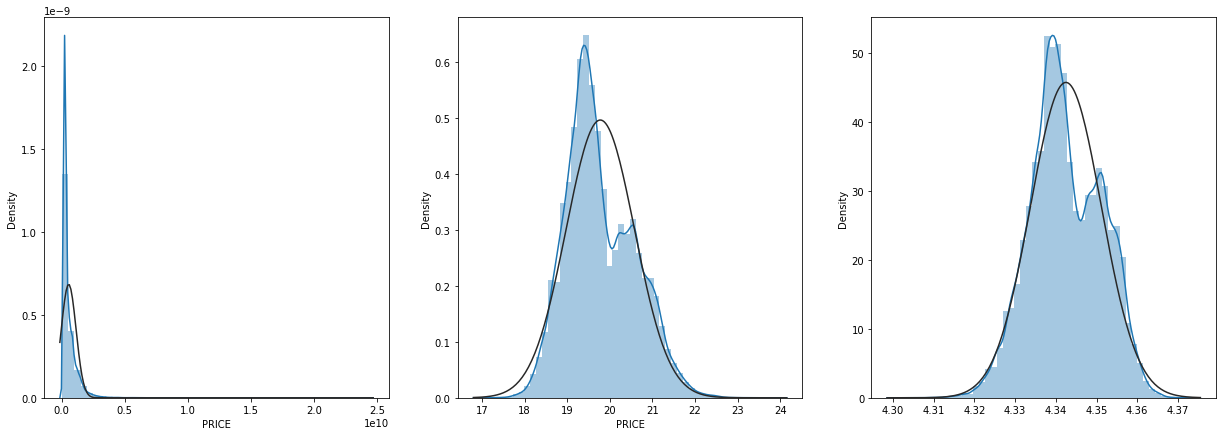

In [63]:
show_skewness('PRICE')

# 3. Preprocessing

## 3.1 Categorical Feature

In [64]:
Town = datas['town_name']

In [65]:
Town = Town.replace(to_replace='강남구', value=1)
Town = Town.replace(to_replace='서초구', value=1)

Town = Town.replace(to_replace='강동구', value=2)
Town = Town.replace(to_replace='광진구', value=2)
Town = Town.replace(to_replace='동작구', value=2)
Town = Town.replace(to_replace='마포구', value=2)
Town = Town.replace(to_replace='성동구', value=2)
Town = Town.replace(to_replace='송파구', value=2)
Town = Town.replace(to_replace='용산구', value=2)
Town = Town.replace(to_replace='종로구', value=2)
Town = Town.replace(to_replace='중구', value=2)

Town = Town.replace(to_replace='강북구', value=3)
Town = Town.replace(to_replace='강서구', value=3)
Town = Town.replace(to_replace='관악구', value=3)
Town = Town.replace(to_replace='구로구', value=3)
Town = Town.replace(to_replace='금천구', value=3)
Town = Town.replace(to_replace='노원구', value=3)
Town = Town.replace(to_replace='도봉구', value=3)
Town = Town.replace(to_replace='동대문구', value=3)
Town = Town.replace(to_replace='서대문구', value=3)
Town = Town.replace(to_replace='성북구', value=3)
Town = Town.replace(to_replace='양천구', value=3)
Town = Town.replace(to_replace='영등포구', value=3)
Town = Town.replace(to_replace='은평구', value=3)
Town = Town.replace(to_replace='중랑구', value=3)


In [66]:
datas['town_name'] = Town

In [67]:
# 원핫 인코딩 한다
data_encoded=pd.get_dummies(datas['house_type'], prefix='house_type')
datas=pd.merge(datas, data_encoded, on='id')
datas=datas.drop(columns='house_type')

In [68]:
data_encoded=pd.get_dummies(datas['town_name'], prefix='town_name')
datas=pd.merge(datas, data_encoded, on='id')
datas=datas.drop(columns='town_name')

## 3.2 Numeric Feature

In [69]:
skew_fixed_datas = datas.apply(lambda col: stats.boxcox(col+0.0001)[0], axis=0)

In [70]:
skew_fixed_datas['PRICE'], lmbda = stats.boxcox(datas['PRICE']+0.0001)

## 3.3 Train test split

In [71]:
X = skew_fixed_datas.drop(columns = ['PRICE'])
y = skew_fixed_datas['PRICE']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.2, random_state = 77)

# 4. Training

In [72]:
# importing required libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")

## Train by skew fixed features

In [73]:
model_RdmForest = RandomForestRegressor()
model_RdmForest.fit(Xtrain, Ytrain)
RdmForest_predictions=model_RdmForest.predict(Xtest)
train_RdmForest=model_RdmForest.predict(Xtrain)

In [74]:
boxcox_train_predictions = (train_RdmForest)
train_score=np.sqrt(mean_squared_error(Ytrain, boxcox_train_predictions))
train_score = special.inv_boxcox(train_score, lmbda)
print(f"Scoring with train data : {train_score}")

boxcox_predictions=(RdmForest_predictions)
predictions=special.inv_boxcox(boxcox_predictions, lmbda)

Scoring with train data : 1.0012052254021957


# 5. Test

In [88]:
X = datas.drop(columns = ['PRICE'])
y = datas['PRICE']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.2, random_state = 77)

In [21]:
Ytest_list = Ytest
np.sqrt(mean_squared_error(Ytest, predictions))

125615194.11952911

In [22]:
# train 종류

boxcox_train_predictions = (train_RdmForest)
train_predictions=special.inv_boxcox(boxcox_train_predictions, lmbda)

Ytrain_list = Ytrain.values

np.sqrt(mean_squared_error(Ytrain_list, train_predictions))

77099733.1599753

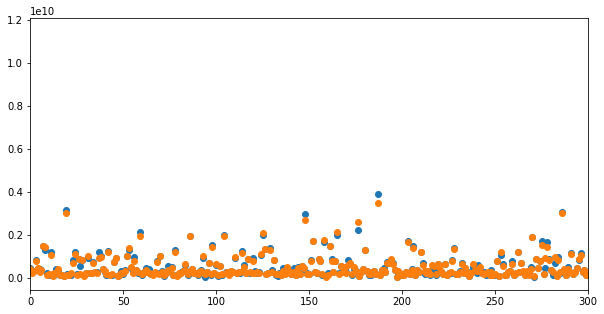

In [23]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 300)
plt.xlim(0, 300)
plt.scatter(np.arange(len(Ytest)), Ytest_list)
plt.scatter(np.arange(len(Ytest)), predictions)

# 6. Extract Results
# - 2020 Data

In [24]:
datas = pd.read_csv('./processed_datas/processed_data_2020.csv', encoding='cp949')
datas.index.name = 'id'
datas.columns

Index(['Unnamed: 0', '공원최단거리', '도서관최단거리', '초등학교최단거리', '중학교최단거리', '고등학교최단거리',
       '지진옥외대피소최단거리', '응급실최단거리', '0.5km지하철', '1.0km지하철', '1.5km지하철', '1.0km병원',
       '2.5km병원', '0.1km버스정류장', '0.3km버스정류장', '0.5km버스정류장', '건물면적', '건물금액',
       '건물주용도', '동네명', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')

In [25]:
datas.columns = ['Unnamed: 0', 'min_park', 'min_book', 'min_elementary', 'min_midsc',
       'min_highsc', 'min_earthquake', 'min_emergency', 
        'station_0.5km', 'station_1.0km', 'station_1.5km', 
        'hospital_1.0km', 'hospital_2.5km', 
        'bus_0.1km', 'bus_0.3km', 'bus_0.5km', 
        'house_area', 'PRICE', 'house_type', 'town_name', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23']
for i in ['Unnamed: 0', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23']:
    datas.drop(columns = i, inplace = True)
    
fit_data = datas[['min_park', 'min_book', 'min_elementary', 'min_midsc', 'min_highsc',
       'min_earthquake', 'min_emergency', 'hospital_1.0km', 'hospital_2.5km', 'bus_0.1km',
       'bus_0.3km', 'bus_0.5km', 'house_area', 'PRICE', 'house_type',
         'station_0.5km', 'station_1.0km', 'station_1.5km','town_name']]

In [26]:
Town = fit_data['town_name']

Town = Town.replace(to_replace='강남구', value=1)
Town = Town.replace(to_replace='서초구', value=1)

Town = Town.replace(to_replace='강동구', value=2)
Town = Town.replace(to_replace='광진구', value=2)
Town = Town.replace(to_replace='동작구', value=2)
Town = Town.replace(to_replace='마포구', value=2)
Town = Town.replace(to_replace='성동구', value=2)
Town = Town.replace(to_replace='송파구', value=2)
Town = Town.replace(to_replace='용산구', value=2)
Town = Town.replace(to_replace='종로구', value=2)
Town = Town.replace(to_replace='중구', value=2)

Town = Town.replace(to_replace='강북구', value=3)
Town = Town.replace(to_replace='강서구', value=3)
Town = Town.replace(to_replace='관악구', value=3)
Town = Town.replace(to_replace='광진구', value=3)
Town = Town.replace(to_replace='구로구', value=3)
Town = Town.replace(to_replace='금천구', value=3)
Town = Town.replace(to_replace='노원구', value=3)
Town = Town.replace(to_replace='도봉구', value=3)
Town = Town.replace(to_replace='동대문구', value=3)
Town = Town.replace(to_replace='서대문구', value=3)
Town = Town.replace(to_replace='성북구', value=3)
Town = Town.replace(to_replace='양천구', value=3)
Town = Town.replace(to_replace='영등포구', value=3)
Town = Town.replace(to_replace='은평구', value=3)
Town = Town.replace(to_replace='중랑구', value=3)

fit_data['town_name'] = Town

In [27]:
Type = fit_data['house_type']

Type = Type.replace(to_replace='아파트', value=1)
Type = Type.replace(to_replace='연립주택', value=2)
Type = Type.replace(to_replace='오피스텔', value=3)

fit_data['house_type'] = Type

In [28]:
# 원핫 인코딩 한다
data_encoded=pd.get_dummies(fit_data['house_type'], prefix='house_type')
fit_data=pd.merge(fit_data, data_encoded, on='id')
fit_data=fit_data.drop(columns='house_type')

In [29]:
data_encoded=pd.get_dummies(fit_data['town_name'], prefix='town_name')
fit_data=pd.merge(fit_data, data_encoded, on='id')
fit_data=fit_data.drop(columns='town_name')

In [30]:
except_y_datas = fit_data.drop(columns='PRICE')

skew_fixed_datas = except_y_datas.apply(lambda col: stats.boxcox(col+0.0001)[0], axis=0)
# PRICE, lmbda = stats.boxcox(fit_datas['PRICE']+0.0001)

In [31]:
predictions = model_RdmForest.predict(skew_fixed_datas)

In [32]:
predictions=special.inv_boxcox(predictions, lmbda)

In [33]:
np.sqrt(mean_squared_error(fit_data['PRICE'],  predictions))

2328552592.017678

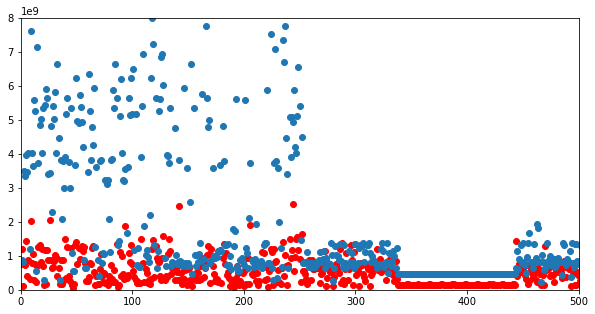

In [34]:
plt.figure(figsize=(10, 5))
plt.xlim(0,500)
plt.ylim(0, 8e9)
plt.scatter(np.arange(len(fit_data['PRICE'])), fit_data['PRICE'], color='red')
plt.scatter(np.arange(len(fit_data['PRICE'])), predictions)

# 6.2 Extract Results
# SM data

In [35]:
dat = pd.read_csv('./processed_datas/sm_data.csv', encoding='cp949')
dat.index.name = 'id'
dat.columns

Index(['Unnamed: 0', 'park_mindist', 'lib_mindist', 'elesch_mindist',
       'midsch_mindist', 'higsch_mindist', 'shell_mindist', 'emer_mindist',
       'hosp_1.0', 'hosp_2.5', 'bus_0.1', 'bus_0.3', 'bus_0.5', 'build_size',
       'build_price', 'build_kind', 'subway_0.5', 'subway_1.0', 'subway_1.5',
       'guindex', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26'],
      dtype='object')

In [36]:
dat.columns = ['Unnamed: 0', 'min_park', 'min_book', 'min_elementary', 'min_midsc',
       'min_highsc', 'min_earthquake', 'min_emergency', 
        'hospital_1.0km', 'hospital_2.5km', 
        'bus_0.1km', 'bus_0.3km', 'bus_0.5km', 
        'house_area', 'PRICE','house_type',
        'station_0.5km', 'station_1.0km', 'station_1.5km', 
        'town_name', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26']

sm_dat = dat[['min_park', 'min_book', 'min_elementary', 'min_midsc', 'min_highsc',
       'min_earthquake', 'min_emergency', 'hospital_1.0km', 'hospital_2.5km', 'bus_0.1km',
       'bus_0.3km', 'bus_0.5km', 'house_area', 'PRICE', 'house_type',
         'station_0.5km', 'station_1.0km', 'station_1.5km','town_name']]

In [37]:
sm_dat.describe()

,min_park,min_book,min_elementary,min_midsc,min_highsc,min_earthquake,min_emergency,hospital_1.0km,hospital_2.5km,bus_0.1km,bus_0.3km,bus_0.5km,house_area,PRICE,house_type,station_0.5km,station_1.0km,station_1.5km
count,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,1.224690e+05,122469.000000,122469.000000,122469.000000,122469.000000
mean,1.008400,0.233807,0.373093,0.506394,0.685183,0.265079,1.407665,5.962227,29.103471,0.886869,8.067233,21.172256,53.585133,5.639462e+08,-0.110207,0.635598,1.578661,2.359234
std,0.512219,0.141951,0.186046,0.258802,0.389402,0.159776,0.776906,4.727687,14.263987,1.275341,4.613001,9.225915,29.406261,6.047414e+08,0.911944,0.754078,1.061703,1.346859
min,0.003000,0.000000,0.003000,0.009000,0.004000,0.002000,0.007000,0.000000,0.000000,0.000000,0.000000,0.000000,6.280000,2.500000e+07,-1.000000,0.000000,0.000000,0.000000
25%,0.634000,0.134000,0.238000,0.311000,0.388000,0.159000,0.830000,2.000000,20.000000,0.000000,5.000000,15.000000,30.460000,2.200000e+08,-1.000000,0.000000,1.000000,2.000000
50%,0.938000,0.211000,0.359000,0.483000,0.625000,0.236000,1.310000,5.000000,28.000000,0.000000,8.000000,20.000000,48.410000,3.370000e+08,0.000000,0.000000,1.000000,2.000000
75%,1.309000,0.302000,0.478000,0.655000,0.906000,0.339000,1.854000,9.000000,36.000000,2.000000,11.000000,27.000000,64.530000,7.050000e+08,1.000000,1.000000,2.000000,3.000000
max,3.234000,1.427000,1.923000,2.305000,4.203000,2.169000,5.696000,32.000000,113.000000,9.000000,32.000000,66.000000,489.790000,2.450000e+10,1.000000,5.000000,7.000000,8.000000


In [38]:
Town = sm_dat['town_name']

Town = Town.replace(to_replace='강남구', value=1)
Town = Town.replace(to_replace='서초구', value=1)

Town = Town.replace(to_replace='강동구', value=2)
Town = Town.replace(to_replace='광진구', value=2)
Town = Town.replace(to_replace='동작구', value=2)
Town = Town.replace(to_replace='마포구', value=2)
Town = Town.replace(to_replace='성동구', value=2)
Town = Town.replace(to_replace='송파구', value=2)
Town = Town.replace(to_replace='용산구', value=2)
Town = Town.replace(to_replace='종로구', value=2)
Town = Town.replace(to_replace='중구', value=2)

Town = Town.replace(to_replace='강북구', value=3)
Town = Town.replace(to_replace='강서구', value=3)
Town = Town.replace(to_replace='관악구', value=3)
Town = Town.replace(to_replace='광진구', value=3)
Town = Town.replace(to_replace='구로구', value=3)
Town = Town.replace(to_replace='금천구', value=3)
Town = Town.replace(to_replace='노원구', value=3)
Town = Town.replace(to_replace='도봉구', value=3)
Town = Town.replace(to_replace='동대문구', value=3)
Town = Town.replace(to_replace='서대문구', value=3)
Town = Town.replace(to_replace='성북구', value=3)
Town = Town.replace(to_replace='양천구', value=3)
Town = Town.replace(to_replace='영등포구', value=3)
Town = Town.replace(to_replace='은평구', value=3)
Town = Town.replace(to_replace='중랑구', value=3)

sm_dat['town_name'] = Town

In [39]:
Type = sm_dat['house_type']

Type = Type.replace(to_replace='-1', value=1)
Type = Type.replace(to_replace='0', value=2)
Type = Type.replace(to_replace='1', value=3)

sm_dat['house_type'] = Type

In [40]:
sm_dat.describe()

,min_park,min_book,min_elementary,min_midsc,min_highsc,min_earthquake,min_emergency,hospital_1.0km,hospital_2.5km,bus_0.1km,bus_0.3km,bus_0.5km,house_area,PRICE,house_type,station_0.5km,station_1.0km,station_1.5km,town_name
count,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,1.224690e+05,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000
mean,1.008400,0.233807,0.373093,0.506394,0.685183,0.265079,1.407665,5.962227,29.103471,0.886869,8.067233,21.172256,53.585133,5.639462e+08,-0.110207,0.635598,1.578661,2.359234,2.284194
std,0.512219,0.141951,0.186046,0.258802,0.389402,0.159776,0.776906,4.727687,14.263987,1.275341,4.613001,9.225915,29.406261,6.047414e+08,0.911944,0.754078,1.061703,1.346859,0.706041
min,0.003000,0.000000,0.003000,0.009000,0.004000,0.002000,0.007000,0.000000,0.000000,0.000000,0.000000,0.000000,6.280000,2.500000e+07,-1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.634000,0.134000,0.238000,0.311000,0.388000,0.159000,0.830000,2.000000,20.000000,0.000000,5.000000,15.000000,30.460000,2.200000e+08,-1.000000,0.000000,1.000000,2.000000,2.000000
50%,0.938000,0.211000,0.359000,0.483000,0.625000,0.236000,1.310000,5.000000,28.000000,0.000000,8.000000,20.000000,48.410000,3.370000e+08,0.000000,0.000000,1.000000,2.000000,2.000000
75%,1.309000,0.302000,0.478000,0.655000,0.906000,0.339000,1.854000,9.000000,36.000000,2.000000,11.000000,27.000000,64.530000,7.050000e+08,1.000000,1.000000,2.000000,3.000000,3.000000
max,3.234000,1.427000,1.923000,2.305000,4.203000,2.169000,5.696000,32.000000,113.000000,9.000000,32.000000,66.000000,489.790000,2.450000e+10,1.000000,5.000000,7.000000,8.000000,3.000000


In [41]:
filt = sm_dat['bus_0.5km'] == -1
sm_dat[filt]['bus_0.5km'] = 0
sm_dat.describe()

,min_park,min_book,min_elementary,min_midsc,min_highsc,min_earthquake,min_emergency,hospital_1.0km,hospital_2.5km,bus_0.1km,bus_0.3km,bus_0.5km,house_area,PRICE,house_type,station_0.5km,station_1.0km,station_1.5km,town_name
count,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,1.224690e+05,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000
mean,1.008400,0.233807,0.373093,0.506394,0.685183,0.265079,1.407665,5.962227,29.103471,0.886869,8.067233,21.172256,53.585133,5.639462e+08,-0.110207,0.635598,1.578661,2.359234,2.284194
std,0.512219,0.141951,0.186046,0.258802,0.389402,0.159776,0.776906,4.727687,14.263987,1.275341,4.613001,9.225915,29.406261,6.047414e+08,0.911944,0.754078,1.061703,1.346859,0.706041
min,0.003000,0.000000,0.003000,0.009000,0.004000,0.002000,0.007000,0.000000,0.000000,0.000000,0.000000,0.000000,6.280000,2.500000e+07,-1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.634000,0.134000,0.238000,0.311000,0.388000,0.159000,0.830000,2.000000,20.000000,0.000000,5.000000,15.000000,30.460000,2.200000e+08,-1.000000,0.000000,1.000000,2.000000,2.000000
50%,0.938000,0.211000,0.359000,0.483000,0.625000,0.236000,1.310000,5.000000,28.000000,0.000000,8.000000,20.000000,48.410000,3.370000e+08,0.000000,0.000000,1.000000,2.000000,2.000000
75%,1.309000,0.302000,0.478000,0.655000,0.906000,0.339000,1.854000,9.000000,36.000000,2.000000,11.000000,27.000000,64.530000,7.050000e+08,1.000000,1.000000,2.000000,3.000000,3.000000
max,3.234000,1.427000,1.923000,2.305000,4.203000,2.169000,5.696000,32.000000,113.000000,9.000000,32.000000,66.000000,489.790000,2.450000e+10,1.000000,5.000000,7.000000,8.000000,3.000000


In [42]:
# 원핫 인코딩 한다
data_encoded=pd.get_dummies(sm_dat['house_type'], prefix='house_type')
sm_dat=pd.merge(sm_dat, data_encoded, on='id')
sm_dat=sm_dat.drop(columns='house_type')

In [43]:
data_encoded=pd.get_dummies(sm_dat['town_name'], prefix='town_name')
sm_dat=pd.merge(sm_dat, data_encoded, on='id')
sm_dat=sm_dat.drop(columns='town_name')

In [44]:
except_y_datas = sm_dat.drop(columns='PRICE')
skew_fixed_datas = except_y_datas.apply(lambda col: stats.boxcox(col+0.0001)[0], axis=0)

In [45]:
skew_fixed_datas.describe()

,min_park,min_book,min_elementary,min_midsc,min_highsc,min_earthquake,min_emergency,hospital_1.0km,hospital_2.5km,bus_0.1km,...,house_area,station_0.5km,station_1.0km,station_1.5km,house_type_-1,house_type_0,house_type_1,town_name_1,town_name_2,town_name_3
count,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,...,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000
mean,-0.068374,-1.170131,-0.823506,-0.635925,-0.441170,-1.163924,0.266489,2.071617,7.588283,-8.079287,...,3.939698,-4.650845,0.287491,0.965611,-5.548603,-687.017035,-15.073988,-969.921229,-8.986794,-8.149236
std,0.517474,0.341406,0.310716,0.378831,0.500490,0.377576,0.651376,2.009512,2.197660,7.472163,...,0.539899,4.812032,1.031410,0.949588,5.299032,295.611690,11.472673,403.497636,7.659217,7.103115
min,-2.138132,-2.477823,-1.930985,-1.901938,-2.285582,-2.759264,-2.006401,-2.387905,-2.193102,-14.522769,...,1.857553,-9.435942,-2.016487,-1.804094,-10.609157,-814.212636,-23.805604,-1137.779186,-15.514426,-14.340394
25%,-0.413862,-1.389564,-1.032729,-0.899916,-0.793305,-1.403311,-0.178742,0.801478,6.317929,-14.522769,...,3.486580,-9.435942,0.000100,0.844122,-10.609157,-814.212636,-23.805604,-1137.779186,-15.514426,-14.340394
50%,-0.063032,-1.163938,-0.806502,-0.616763,-0.429825,-1.165132,0.286913,2.277582,7.710635,-14.522769,...,3.970358,-9.435942,0.000100,0.844122,-10.609157,-814.212636,-23.805604,-1137.779186,-15.514426,-14.340394
75%,0.285490,-0.954996,-0.619947,-0.383791,-0.096759,-0.919674,0.709999,3.561182,8.896980,0.671469,...,4.271830,0.000100,0.825619,1.509640,0.000100,-814.212636,0.000100,-1137.779186,0.000100,0.000100
max,1.525112,0.381680,0.769992,1.021513,1.916739,0.874528,2.620538,7.646529,16.358399,1.988598,...,6.427171,1.602698,3.256489,3.891878,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100


In [46]:
predictions = model_RdmForest.predict(skew_fixed_datas)

In [47]:
predictions=special.inv_boxcox(predictions, lmbda)

In [48]:
np.sqrt(mean_squared_error(sm_dat['PRICE'],  predictions))

381750805.7602978

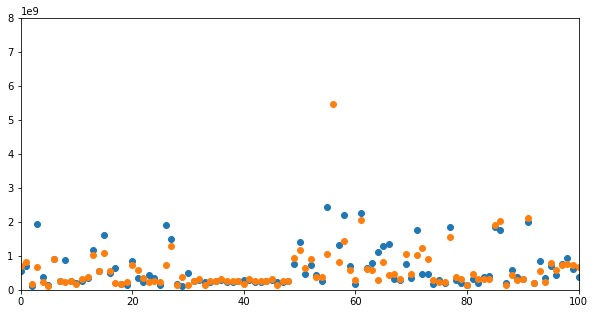

In [49]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 100)
plt.ylim(0, 8e9)
plt.scatter(np.arange(len(sm_dat['PRICE'])), sm_dat['PRICE'])
plt.scatter(np.arange(len(sm_dat['PRICE'])), predictions)

# 구 별로 지역추천해보자
- model: 2021 train data로 훈련된 모델
- data: 2021 test data로 prediction할 거임.

## - 일단 test data들을 가져오고 구 별로 평가액 차이를 구함
## - 이후  평가액 차이를 구해 df 안에 넣는다

In [89]:
new_data = Xtest
new_data['PRICE'] = Ytest
new_data['predicted_PRICE'] = predictions
new_data.reset_index(drop=True, inplace=True)
new_data.head()

,min_park,min_book,min_elementary,min_midsc,min_highsc,min_earthquake,min_emergency,hospital_1.0km,hospital_2.5km,bus_0.1km,bus_0.3km,bus_0.5km,house_area,house_type,station_0.5km,station_1.0km,station_1.5km,town_name,PRICE,predicted_PRICE
0,1.069,0.346,0.269,0.269,0.269,0.352,1.223,3,18,0,11,20,51.95,-1,0,2,4,서대문구,460000000,4.088105e+08
1,1.219,0.305,0.511,0.285,1.609,0.070,1.386,13,42,0,4,17,39.40,-1,0,1,1,강서구,290000000,2.232173e+08
2,1.930,0.025,0.324,0.547,0.413,0.384,0.930,7,42,0,8,25,29.73,-1,0,2,3,구로구,325000000,3.193483e+08
3,1.027,0.329,0.097,0.262,0.412,0.133,0.647,2,18,2,7,16,84.83,1,1,1,2,노원구,855000000,7.988868e+08
4,0.702,0.219,0.721,0.489,0.489,0.291,1.370,4,19,1,9,25,68.56,-1,0,3,4,마포구,438000000,4.674067e+08


In [90]:
gu_columns = ['강남구','서초구', '강동구','광진구','동작구','마포구','성동구',
              '송파구','용산구','종로구','중구','강북구', '강서구','관악구',
              '구로구','금천구','노원구','도봉구', '동대문구','서대문구',
              '성북구','양천구','영등포구','은평구','중랑구']

In [91]:
df = pd.DataFrame(columns= gu_columns)
gu_difference = []
for gu in gu_columns:
    diff = []
    gu_data = new_data[new_data['town_name']==gu]
    gu_data.reset_index(drop=True, inplace=True)
    diff = gu_data['PRICE'] - gu_data['predicted_PRICE']
    df[gu] = diff
    difference = np.mean(np.abs(diff))
    gu_difference.append(difference)

- 구 별 가격차이를 abs 한 후 그냥 몽땅 더해서 그린 그래프. 
- '차이'의 정도만 볼 수 있을것 같아 평가정도가 정확하지 않을 것 같아서 아래 그래프 하나 더 그렸음.

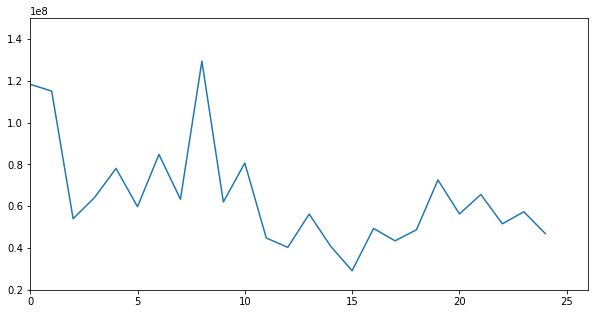

In [115]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 26)
plt.ylim(0.2e8, 1.5e8)
plt.plot(gu_difference)

In [92]:
df

,강남구,서초구,강동구,광진구,동작구,마포구,성동구,송파구,용산구,종로구,...,금천구,노원구,도봉구,동대문구,서대문구,성북구,양천구,영등포구,은평구,중랑구
0,7.083515e+06,3.519130e+08,-1.653720e+07,7.062524e+07,-1.312906e+08,-2.940668e+07,-7.443449e+07,5.940226e+07,-1.783301e+06,2.321983e+07,...,-4.370026e+06,5.611318e+07,9.355655e+07,-1.458570e+07,5.118950e+07,1.285843e+08,3.592805e+07,5.694544e+07,1.658490e+08,3.276513e+07
1,-8.877708e+06,-2.557036e+06,4.459608e+06,-2.887529e+07,2.667341e+07,-1.202531e+07,3.555632e+07,-5.825528e+06,-5.495759e+06,-1.065397e+08,...,2.012319e+07,5.545869e+07,1.072036e+07,3.610438e+06,-1.081571e+07,-2.424864e+05,6.541755e+06,4.267050e+06,3.343028e+08,-4.674172e+07
2,1.781110e+07,-3.322890e+06,1.545686e+05,-4.423726e+07,2.643794e+07,-9.883745e+07,-2.932566e+06,3.634810e+07,-9.677703e+06,4.741574e+07,...,2.672795e+06,1.195898e+07,4.489258e+07,-5.955685e+06,8.652037e+07,6.129207e+07,2.427422e+07,-2.051290e+06,-2.963082e+07,2.594753e+07
3,-1.249532e+07,4.453228e+07,-4.935148e+06,-1.032131e+07,8.320808e+07,-6.391692e+07,6.639692e+07,-8.836292e+06,-2.452586e+07,-2.703724e+07,...,-5.357978e+07,-4.649105e+06,8.323121e+06,-2.180358e+07,2.231596e+07,2.427297e+08,-1.179628e+07,-7.288107e+07,2.185176e+06,4.769369e+07
4,-6.158877e+06,-1.123952e+07,1.729807e+06,1.224240e+08,-6.041915e+06,2.059764e+08,2.585332e+07,1.207021e+08,1.211404e+08,6.327859e+06,...,4.629748e+07,2.473089e+06,-1.565673e+07,2.962660e+07,2.746575e+07,-7.695494e+07,3.253779e+07,3.952774e+06,-5.092747e+07,5.782044e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,-7.576060e+07,NaN,1.653475e+07,NaN,NaN,NaN,NaN,2.792204e+06,NaN,NaN,...,NaN,NaN,2.955841e+07,NaN,NaN,NaN,1.073588e+07,NaN,5.435246e+06,NaN
1006,-1.992093e+07,NaN,6.027517e+07,NaN,NaN,NaN,NaN,-5.647614e+06,NaN,NaN,...,NaN,NaN,2.738915e+07,NaN,NaN,NaN,9.067233e+07,NaN,3.349773e+07,NaN
1007,1.323266e+08,NaN,-1.049639e+08,NaN,NaN,NaN,NaN,-8.916790e+06,NaN,NaN,...,NaN,NaN,1.466875e+07,NaN,NaN,NaN,-3.606276e+07,NaN,1.327149e+07,NaN
1008,7.767041e+06,NaN,-1.948584e+08,NaN,NaN,NaN,NaN,9.780032e+06,NaN,NaN,...,NaN,NaN,5.700456e+07,NaN,NaN,NaN,-7.737577e+07,NaN,-6.392482e+06,NaN


In [110]:
predict_distribution = []
result = []
for gu in gu_columns:
    count=0
    high = 0
    low = 0
    col = df[gu]
    col.dropna(inplace=True)
    for element in col:
        if element > 0:
            count +=1
            high += element
        else:
            low = element
    res = high + low
    result.append(res/len(col))
    predict_distribution.append(count/len(col))
    col.drop(columns=gu, inplace=True)

- 이하는 양의 차이와 음의 차이의 분포 정도를 나타낸 것임.
   - 산출 방법: 고평가된 데이터 수 / 전체 데이터 수
- 보다시피 양의 차이와 음의 차이의 개수가 그렇게 크게 차이나지 않음.
- 예를 들어 50% 이상 는 고평가된 데이터가 저평가된 데이터보다 많다는 의미.

In [112]:
predict_distribution

[0.5217821782178218,
 0.5177514792899408,
 0.5138613861386139,
 0.4971014492753623,
 0.5342960288808665,
 0.5115115115115115,
 0.5268817204301075,
 0.5128712871287129,
 0.5339966832504146,
 0.48753462603878117,
 0.4907749077490775,
 0.49042553191489363,
 0.497029702970297,
 0.5420765027322404,
 0.5182186234817814,
 0.5704874835309618,
 0.4618015963511973,
 0.49504950495049505,
 0.561119293078056,
 0.522342064714946,
 0.5243770314192849,
 0.5544554455445545,
 0.5524625267665952,
 0.5663366336633663,
 0.49486887115165334]

- 이 그림은 양의 차이의 합(-) + 음의 차이의 합(-) 을 구해 그린 것.
    - 산출 방법: (양의 차이 합 + 음의 차이 합) / 각 구 데이터 수
- 모든 차이들의 절댓값을 더한 지표보다 '지역의 고, 저평가'를 대표하기 좋을 것으로 판단.
- 아래에서 첫 번째 구 (강남구)는 7000만원정도 고평가되었다고 나옴.
- 모든 데이터가 저평가되지는 않았다고 결과가 나옴. (이건 모델의 한계인 듯)

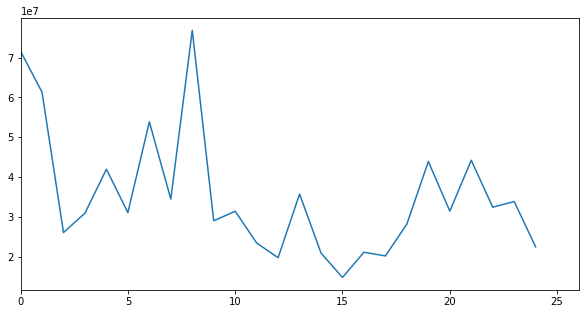

In [113]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 26)
plt.plot(result)

- 결론적으로 위의 그래프에서 얻을 수 있는 결과는 아래와 같음
- 강남구, 서초구, 성동구, 용산구가 고평가 된 지역임
- 각각 7100, 6100, 5300, 7600 만원정도씩 고평가 되었음. 
- 하지만 모델의 prediction error가 1.2억인데.. 저 오차.. 믿을수 있을까..?

In [141]:
res_df = pd.DataFrame(columns=gu_columns)
for i, gu in enumerate(gu_columns):
    res_df[gu] = [result[i]]
res_df

,강남구,서초구,강동구,광진구,동작구,마포구,성동구,송파구,용산구,종로구,...,금천구,노원구,도봉구,동대문구,서대문구,성북구,양천구,영등포구,은평구,중랑구
0,7.157998e+07,6.130839e+07,2.609373e+07,3.096175e+07,4.199608e+07,3.109560e+07,5.387220e+07,3.450722e+07,7.682872e+07,2.904691e+07,...,1.482473e+07,2.115664e+07,2.022223e+07,2.822641e+07,4.392779e+07,3.147418e+07,4.421772e+07,3.244437e+07,3.388003e+07,2.248478e+07


In [144]:
res_df[res_df > 50000000]

,강남구,서초구,강동구,광진구,동작구,마포구,성동구,송파구,용산구,종로구,...,금천구,노원구,도봉구,동대문구,서대문구,성북구,양천구,영등포구,은평구,중랑구
0,7.157998e+07,6.130839e+07,NaN,NaN,NaN,NaN,5.387220e+07,NaN,7.682872e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
